## Libraries

In [23]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
import os
from torchinfo import summary
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import seaborn as sns

## Data processing & EDA

In [24]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [25]:
imagedir = Path('images/images/')

In [26]:
os.listdir(imagedir)[:5]

['parasect.png', 'lumineon.png', 'raikou.png', 'comfey.jpg', 'dedenne.png']

In [27]:
all_images = list(imagedir.glob('*.png'))

In [28]:
all_images[:5]

[PosixPath('images/images/parasect.png'),
 PosixPath('images/images/lumineon.png'),
 PosixPath('images/images/raikou.png'),
 PosixPath('images/images/dedenne.png'),
 PosixPath('images/images/pyroar.png')]

In [29]:
df = pd.read_csv('pokemon.csv').loc[:,:'Type1']

In [30]:
df.head()

,Name,Type1
0,bulbasaur,Grass
1,ivysaur,Grass
2,venusaur,Grass
3,charmander,Fire
4,charmeleon,Fire


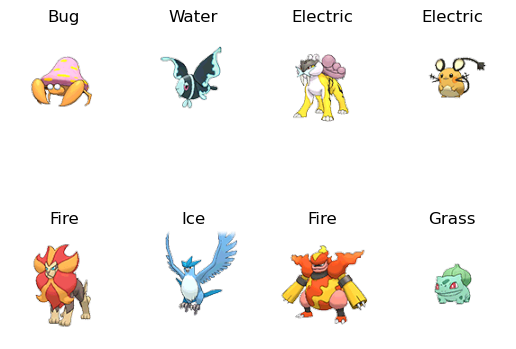

In [31]:
for i in range(0,8):
    plt.subplot(2, 4, i+1)
    plt.imshow(plt.imread(all_images[i]))
    plt.title(df[df['Name']==all_images[i].stem]['Type1'].item())
    plt.axis('off')

In [32]:
all_type = df['Type1'].unique()

In [33]:
classtotype = {i:t for i,t in enumerate(all_type)}
typetoclass = {n:i for i,n in classtotype.items()}
typetoclass

{'Grass': 0,
 'Fire': 1,
 'Water': 2,
 'Bug': 3,
 'Normal': 4,
 'Poison': 5,
 'Electric': 6,
 'Ground': 7,
 'Fairy': 8,
 'Fighting': 9,
 'Psychic': 10,
 'Rock': 11,
 'Ghost': 12,
 'Ice': 13,
 'Dragon': 14,
 'Dark': 15,
 'Steel': 16,
 'Flying': 17}

In [34]:
df['Type1'].value_counts()[:3]

Water     114
Normal    105
Grass      78
Name: Type1, dtype: int64

In [35]:
df_train_set, valtest_set = train_test_split(df, test_size=0.4, random_state=42)
df_val_set, df_test_set = train_test_split(valtest_set, test_size=0.5 )

In [36]:
class dataset_maker(Dataset):
    def __init__(self,df,dic,imagepath,transform=None):
        self.df = df
        self.dic =dic
        self.imagepath = imagepath
        self.transform = transform

    def __len__(self):
        return len(self.imagepath)
    
    def __getitem__(self, index):
        data_row = df.iloc[index]
        target = self.dic[data_row['Type1']]
        image = Image.open([n for n in self.imagepath if n.stem == data_row['Name']][0]).convert('RGB')

        if self.transform:
            image = self.transform(image)


        return image, target
    

    def target(self):
        target = []
        for index in range(len(self)):
            x,y = self.__getitem__(index)
            target.append(y)
        return target
        
        

In [37]:
transformer = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [38]:
train_set = DataLoader(dataset_maker(df_train_set,typetoclass,all_images,transformer),batch_size=32,shuffle=True)
val_set = DataLoader(dataset_maker(df_val_set, typetoclass,all_images,transformer),batch_size=32)

In [39]:
test_set = DataLoader(dataset_maker(df_test_set, typetoclass,all_images,transformer), batch_size=32)
test_target = dataset_maker(df_test_set,typetoclass,all_images,transformer)

In [40]:
next(iter(train_set))

/Users/pongsakorntanupatrasakul/miniconda3/envs/poomtorch/lib/python3.11/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

## Model Creation

In [41]:
resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT).to(device)

In [42]:
for param in resnet.parameters():
    param.requires_grad = False

In [43]:
summary(resnet,input_size=(1,3,256,256), col_names=["input_size", "output_size", "num_params", "trainable"], device='mps')

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [1, 3, 256, 256]          [1, 1000]                 --                        False
├─Conv2d: 1-1                            [1, 3, 256, 256]          [1, 64, 128, 128]         (9,408)                   False
├─BatchNorm2d: 1-2                       [1, 64, 128, 128]         [1, 64, 128, 128]         (128)                     False
├─ReLU: 1-3                              [1, 64, 128, 128]         [1, 64, 128, 128]         --                        --
├─MaxPool2d: 1-4                         [1, 64, 128, 128]         [1, 64, 64, 64]           --                        --
├─Sequential: 1-5                        [1, 64, 64, 64]           [1, 64, 64, 64]           --                        False
│    └─BasicBlock: 2-1                   [1, 64, 64, 64]           [1, 64, 64, 64]           --                        False
│ 

In [44]:
resnet.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(512,len(all_type))
).to(device)

In [45]:
next(resnet.parameters()).device

device(type='mps', index=0)

## Training

In [46]:
def train_loop(data, model, loss_fn, optimizer, acc_fn, device, epoch):
    total_loss = 0
    total_acc = 0
    model.train()
    for X,y in data:
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        total_acc+=acc_fn(y_pred,y)
        total_loss+=loss_fn(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_acc/=len(data)
    total_loss/=len(data)
    print(f'epoch {epoch+1} train loss: {total_loss} train acc : {total_acc}')
    return total_loss,total_acc




def val_loop(data, model, loss_fn, optimizer, acc, device, epoch):
    total_loss = 0
    total_acc = 0
    model.eval()
    with torch.inference_mode():
        for X,y in data:
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred,y)
            total_loss+=loss
            total_acc+=acc(y_pred,y)
        total_acc/=len(data)
        total_loss/=len(data)
        print(f'epoch {epoch+1} val loss: {total_loss} val acc : {total_acc}')
        return total_loss,total_acc


def fit_loop(train_data,val_data, model,acc_fn,loss_fn,optimizer,device,epoch):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    for i in range(0,epoch):
        train_loss,train_acc = train_loop(train_data,resnet,loss_fn,optimizer,acc_fn,device,i)
        val_loss,val_acc = val_loop(val_data,resnet,loss_fn,optimizer,acc_fn,device,i)
        train_loss_list.append(train_loss.item())
        train_acc_list.append(train_acc.item())
        val_loss_list.append(val_loss.item())
        val_acc_list.append(val_acc.item())
    return train_loss_list,train_acc_list,val_loss_list,val_acc_list


        

In [47]:
optimizer = torch.optim.Adam(resnet.parameters())
loss_fn = torch.nn.CrossEntropyLoss().to(device)
acc_fn = Accuracy('multiclass',num_classes=len(all_type)).to(device)

In [48]:
epoch=50

In [49]:
train_loss,train_acc,val_loss,val_acc = fit_loop(train_data=train_set,val_data=val_set,model=resnet,acc_fn=acc_fn,loss_fn=loss_fn,optimizer=optimizer,device=device,epoch=epoch)

epoch 1 train loss: 2.9693992137908936 train acc : 0.11548913270235062
epoch 1 val loss: 2.6780710220336914 val acc : 0.13722826540470123
epoch 2 train loss: 2.729975938796997 train acc : 0.13930626213550568
epoch 2 val loss: 2.470862865447998 val acc : 0.24048912525177002
epoch 3 train loss: 2.5956227779388428 train acc : 0.18941815197467804
epoch 3 val loss: 2.3217551708221436 val acc : 0.2919597327709198
epoch 4 train loss: 2.44848895072937 train acc : 0.21523337066173553
epoch 4 val loss: 2.2189831733703613 val acc : 0.29859334230422974
epoch 5 train loss: 2.3539586067199707 train acc : 0.26838237047195435
epoch 5 val loss: 2.1083219051361084 val acc : 0.35158249735832214
epoch 6 train loss: 2.2808759212493896 train acc : 0.28348785638809204
epoch 6 val loss: 2.020921230316162 val acc : 0.3746803104877472
epoch 7 train loss: 2.239581346511841 train acc : 0.3062659800052643
epoch 7 val loss: 1.9302998781204224 val acc : 0.42918798327445984
epoch 8 train loss: 2.1432127952575684 trai

## Model evaluation

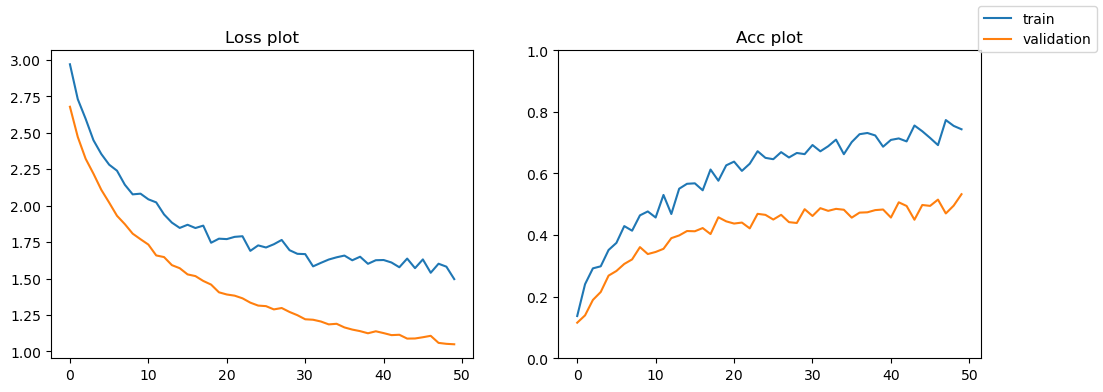

In [50]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize = (12,4))
ax[0].plot(range(epoch),train_loss,label ='train')
ax[0].set_title('Loss plot')
ax[1].set_ylim(0,1)
ax[0].plot(range(epoch),val_loss , label = 'validation')
ax[1].plot(range(epoch),val_acc)
ax[1].plot(range(epoch),train_acc)
ax[1].set_title('Acc plot');
fig.legend()

In [51]:
test_set = DataLoader(dataset_maker(df_test_set, typetoclass,all_images,transformer), batch_size=32)
test_target = dataset_maker(df_test_set,typetoclass,all_images,transformer).target()

In [52]:
resnet.eval()
y_preds = []
with torch.inference_mode():
    for X,y in test_set:
        X,y = X.to(device),y.to(device)
        y_logits = resnet(X)
        y_pred = y_logits.argmax(axis=1)
        y_preds.append(y_pred)

In [61]:
y_true = torch.tensor(test_target)
y_pred_list = torch.cat(y_preds).to('cpu')

In [64]:
acc_fn(y_pred_list,y_true)

tensor(0.7406, device='mps:0')